<a href="https://colab.research.google.com/github/GAKIZAB/Traitement-des-audios/blob/main/traitement_des_audios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [01:44<00:00, 23.2MB/s]


In [24]:
# Assuming 'waveform' is a tensor representing the audio
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [16]:
# prompt: donne le code qui affiche tous les labels disponible dans la data

labels = sorted(list(set([train_set[i][2] for i in range(len(train_set))])))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

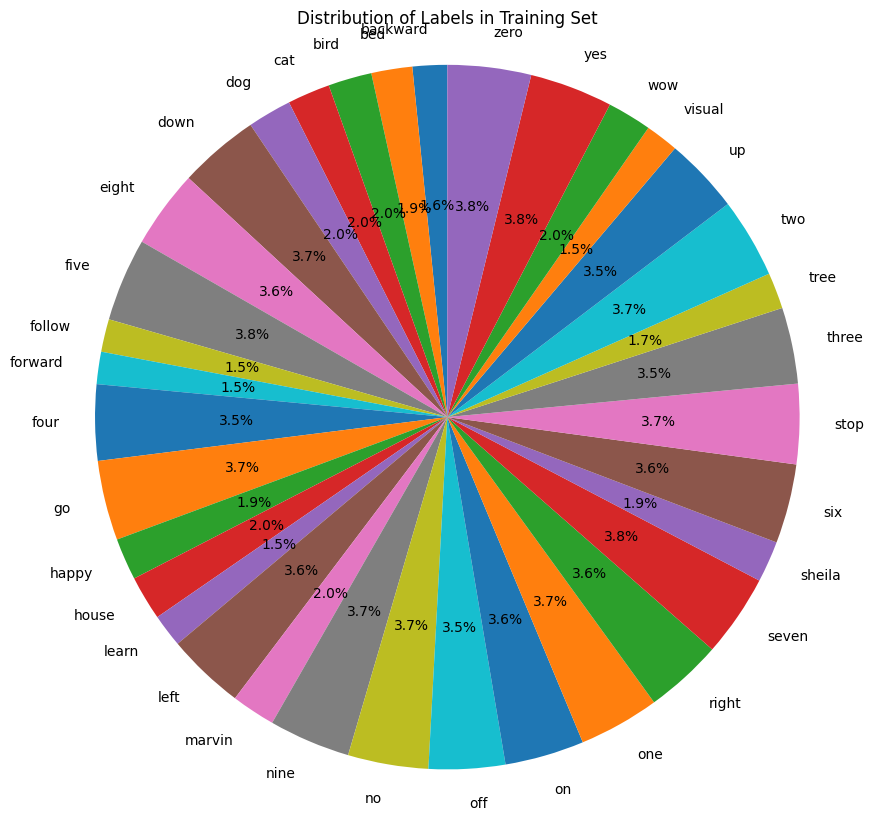

In [25]:
# prompt: donne un diagramme en pie pour afficher les differents labels et les pourcentage qu'il occupe

import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = {}
for i in range(len(train_set)):
    label = train_set[i][2]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Prepare data for the pie chart
labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Labels in Training Set')
plt.show()

cuda


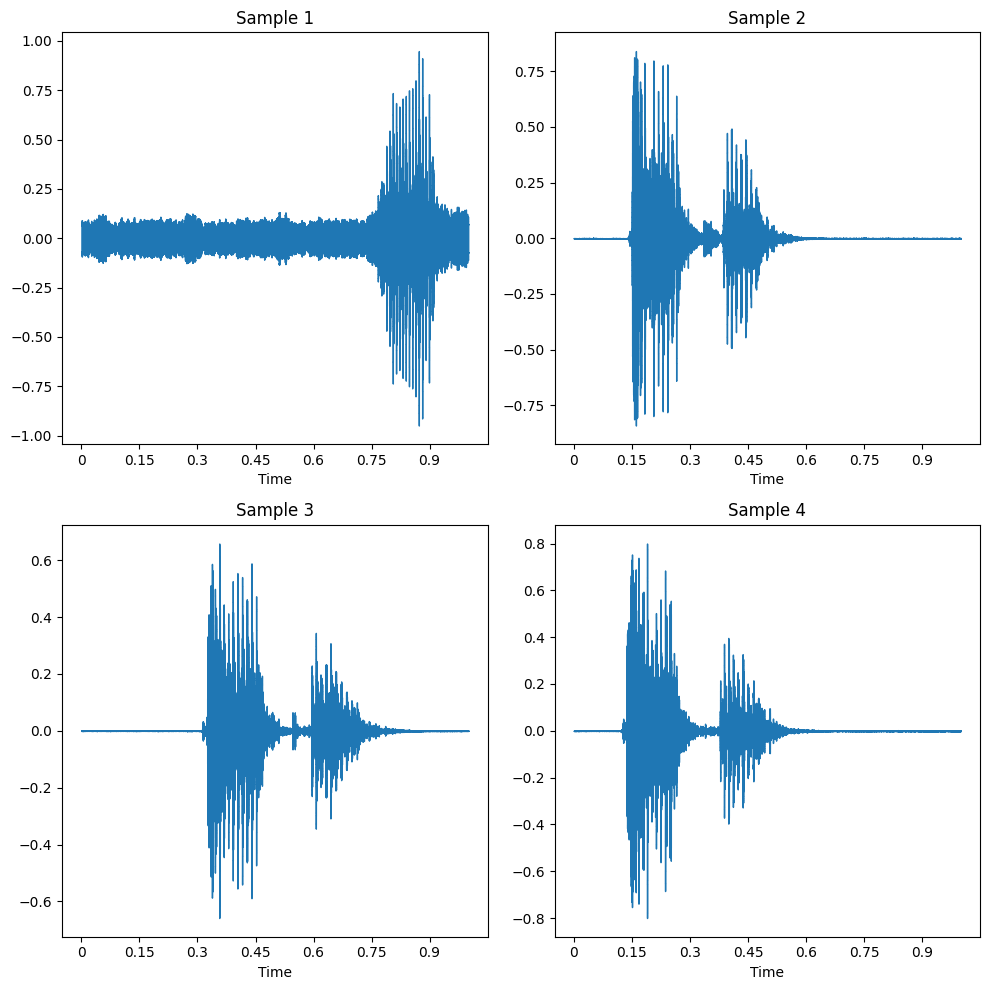

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from torchaudio.datasets import SPEECHCOMMANDS
import os
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, fixed_length=16000): # set the length
        super().__init__("./", download=True)
        self.fixed_length = fixed_length

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

    def __getitem__(self, index):
        waveform, sample_rate, label, speaker_id, utterance_number = super().__getitem__(index)

        # Pad or truncate waveform to fixed length
        if waveform.size(1) < self.fixed_length:
            padding = self.fixed_length - waveform.size(1)
            waveform = torch.cat((waveform, torch.zeros(1, padding)), dim=1)
        elif waveform.size(1) > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]

        return waveform, sample_rate, label, speaker_id, utterance_number


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


# %%
# Assuming 'waveform' is a tensor representing the audio
ipd.Audio(waveform.numpy(), rate=sample_rate)
# %%
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch

# Assuming you have four waveforms (replace with your actual waveforms)
waveforms = []
for i in range(4):
    waveform, sample_rate, _, _, _ = train_set[i]
    waveforms.append(waveform)

# Create subplots arranged in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, waveform in enumerate(waveforms):
    row = i // 2  # Calculate row index
    col = i % 2  # Calculate column index

    # Convert waveform to numpy array if it's a tensor
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()
    # Display the waveform
    librosa.display.waveshow(waveform, sr=sample_rate, ax=axes[row, col])
    axes[row, col].set_title(f'Sample {i + 1}')

plt.tight_layout()
plt.show()
# %%
# prompt: donne le code qui affiche tous les labels disponible dans la data

labels = sorted(list(set([train_set[i][2] for i in range(len(train_set))])))
labels
# %%
# prompt: donne un diagramme en pie pour afficher les differents labels et les pourcentage qu'il occupe

import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = {}
for i in range(len(train_set)):
    label = train_set[i][2]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Prepare data for the pie chart
labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Labels in Training Set')
plt.show()
# %%
# prompt: donne un code CNN avec 2D

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN2D(nn.Module):
    def __init__(self, num_classes):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # Adjust input size based on your data
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) # Adjust input size based on your data
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x
# %%
# prompt: fait le test pour les donne d'entrainement

# Assuming 'train_set' is your training dataset and 'CNN2D' is your model class
#  and you've defined 'labels' as a list of all possible labels.

# Define hyperparameters
batch_size = 64  # Adjust as needed
learning_rate = 0.001
num_epochs = 10 # Adjust as needed

# Create data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Instantiate the model
num_classes = len(labels) # Number of classes in your dataset
model = CNN2D(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels_tensor = data[0].to(device), data[2].to(device) # Assuming data[2] contains the label

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.unsqueeze(1))

        # Convert labels to numerical indices
        label_indices = torch.tensor([labels.index(label) for label in labels_tensor], device=device)


        # Calculate the loss
        loss = criterion(outputs, label_indices)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')
# %%
# prompt: applique les test et la validation

# Assuming 'test_set' is your testing dataset and 'model' is your trained model.

# Define batch size for testing
batch_size = 64  # Adjust as needed

# Create data loader for testing
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation during testing
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels_tensor = data[0].to(device), data[2].to(device)
        # Make sure input shape is correct for your model
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)

        # Convert string labels to numerical indices
        label_indices = torch.tensor([labels.index(label) for label in labels_tensor], device=device)

        total += labels_tensor.size(0)
        correct += (predicted == label_indices).sum().item()


print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))
# %%
# prompt: fait la validation du model

# Assuming 'test_set' is your testing dataset and 'model' is your trained model.

# Define batch size for testing
batch_size = 64  # Adjust as needed

# Create data loader for testing
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize variables to track accuracy
correct = 0
total = 0

# Define a confusion matrix
confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

# Disable gradient calculation during testing
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels_tensor = data[0].to(device), data[2].to(device)
        # Make sure input shape is correct for your model
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)

        # Convert string labels to numerical indices
        label_indices = torch.tensor([labels.index(label) for label in labels_tensor], device=device)

        for t, p in zip(label_indices.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        total += labels_tensor.size(0)
        correct += (predicted == label_indices).sum().item()

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))


# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


# Calculate and print precision, recall, and F1-score for each class
for i in range(num_classes):
    true_positives = confusion_matrix[i, i].item()
    false_positives = confusion_matrix[:, i].sum().item() - true_positives
    false_negatives = confusion_matrix[i, :].sum().item() - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class {labels[i]}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1_score:.4f}")

In [ ]:
# prompt: applique les test et la validation

# Assuming 'test_set' is your testing dataset and 'model' is your trained model.

# Define batch size for testing
batch_size = 64  # Adjust as needed

# Create data loader for testing
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation during testing
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels_tensor = data[0].to(device), data[2].to(device)
        # Make sure input shape is correct for your model
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)

        # Convert string labels to numerical indices
        label_indices = torch.tensor([labels.index(label) for label in labels_tensor], device=device)

        total += labels_tensor.size(0)
        correct += (predicted == label_indices).sum().item()


print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

In [ ]:
# prompt: fait la validation du model

# Assuming 'test_set' is your testing dataset and 'model' is your trained model.

# Define batch size for testing
batch_size = 64  # Adjust as needed

# Create data loader for testing
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize variables to track accuracy
correct = 0
total = 0

# Define a confusion matrix
confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

# Disable gradient calculation during testing
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels_tensor = data[0].to(device), data[2].to(device)
        # Make sure input shape is correct for your model
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)

        # Convert string labels to numerical indices
        label_indices = torch.tensor([labels.index(label) for label in labels_tensor], device=device)

        for t, p in zip(label_indices.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        total += labels_tensor.size(0)
        correct += (predicted == label_indices).sum().item()

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))


# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


# Calculate and print precision, recall, and F1-score for each class
for i in range(num_classes):
    true_positives = confusion_matrix[i, i].item()
    false_positives = confusion_matrix[:, i].sum().item() - true_positives
    false_negatives = confusion_matrix[i, :].sum().item() - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class {labels[i]}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1_score:.4f}")